# Sample Model to Predict Taxi Cab Trip Time

##### This notebook will contain the model script to generate predictions for trip time to be used with the Kubeflow pipelines established. Any model can replace this one to illustrate the functionality of the MLOPS environment.

In [1]:
##load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from io import BytesIO
from google.cloud import storage

In [2]:
##connect to training dataset
storage_client = storage.Client()
bucket = storage_client.get_bucket('mlops_model_input')
file = '/data_input/Taxi_Trips_3mo.csv'
blob = bucket.blob(file)
path = "gs://mlops_model_input" + file
df = pd.read_csv(path)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
##print the top 5 records of imported dataset
df.head(2)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,3e1ac82501797e2e6cd020d2eb6a47774add503f,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,"1,140",6.4,NaN,NaN,28.0,6.0,...,0.0,25.35,Credit Card,Medallion Leasin,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,3adf277e43154ac0cd099c7bb7137f75dcfded95,d24314a66ebc6319a50cc335d6896612b845ca15f702ee...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,420,1.3,NaN,NaN,8.0,8.0,...,0.0,7.00,Cash,Top Cab Affiliation,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


In [4]:
df['Trip Start Timestamp'].isna().sum()

0

In [5]:
df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])

In [6]:
df['Trip End Timestamp'] = pd.to_datetime(df['Trip End Timestamp'])

In [7]:
df['start_dow'] = df['Trip Start Timestamp'].dt.day_name()

In [8]:
from datetime import datetime, date, time, timedelta

In [9]:
df['start_time_seconds'] = (pd.to_timedelta(df['Trip Start Timestamp'].dt.time.astype(str)) -pd.Timedelta("0 days")).dt.total_seconds()

In [10]:
df[['Trip Start Timestamp','start_time_seconds']].sample(3)

,Trip Start Timestamp,start_time_seconds
279895,2021-02-24 18:30:00,66600.0
466781,2021-03-25 18:45:00,67500.0
128702,2021-01-28 05:15:00,18900.0


Try and make pickup/dropoff string --> numeric makes no sense?

In [11]:
df.head(1).T

,0
Trip ID,3e1ac82501797e2e6cd020d2eb6a47774add503f
Taxi ID,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...
Trip Start Timestamp,2021-01-01 00:15:00
Trip End Timestamp,2021-01-01 00:30:00
Trip Seconds,"1,140"
Trip Miles,6.4
Pickup Census Tract,NaN
Dropoff Census Tract,NaN
Pickup Community Area,28.0
Dropoff Community Area,6.0


In [12]:
##check dimensions of imported file
rows = df.shape[0]
cols = df.shape[1]
print(rows)
print(cols)

511131
25


#### Our Model will use and try to predict the total number of Trip Seconds and we will set that to be the dependent variable

In [13]:
#TO-DO remove any records with 0 Trip Seconds!
##remove null values!

In [14]:
x_cols = ["Pickup Centroid Latitude","Pickup Centroid Longitude", "Dropoff Centroid Longitude", 
          "Dropoff Centroid Latitude", "Company",'start_time_seconds',
    'start_dow','Trip Miles']

In [15]:
len(df)

511131

In [16]:
df[x_cols+['Trip Seconds']].isna().sum()

Pickup Centroid Latitude      36571
Pickup Centroid Longitude     36571
Dropoff Centroid Longitude    59493
Dropoff Centroid Latitude     59493
Company                           0
start_time_seconds                0
start_dow                         0
Trip Miles                        2
Trip Seconds                    274
dtype: int64

In [17]:
df['start_dow'].value_counts()

Friday       82467
Wednesday    81155
Monday       80523
Tuesday      77692
Thursday     77345
Saturday     62032
Sunday       49917
Name: start_dow, dtype: int64

In [18]:
len(df)

511131

In [19]:
df = df.dropna(subset=x_cols+['Trip Seconds'])

In [20]:
df.columns.str.contains("trip seconds", case = False)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [21]:
df['Trip Seconds'].value_counts()

0         12786
360       11600
300       11490
420       11476
480       10777
          ...  
4,191         1
39,198        1
3,637         1
4,820         1
13,644        1
Name: Trip Seconds, Length: 6179, dtype: int64

In [22]:
df['Trip Seconds'] = df['Trip Seconds'].str.replace(',','').astype(int)

<AxesSubplot:ylabel='Frequency'>

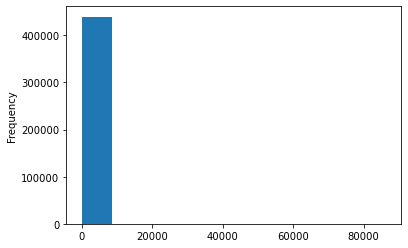

In [23]:
df['Trip Seconds'].plot.hist()

In [24]:
df = df[df['Trip Seconds'] > 0]

In [25]:
## create our training data sets with the independent vars. 
## X = Independent Vars: taxi cab company, pickup community area, and drop off community 
## Y = Var we are trying to predict : trip time in seconds

X_run_cols = [x in x_cols for x in df.columns]
Y_col = df.columns.str.contains("trip seconds", case = False)
print(X_run_cols)
print(Y_col)
X = df.iloc[:, X_run_cols]
Y = df.iloc[:, Y_col]
print(X.head())
print(Y.head())


[False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, True, False, True, True, False, True, True]
[False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False]
   Trip Miles              Company  Pickup Centroid Latitude  \
0        6.40     Medallion Leasin                 41.874005   
1        1.30  Top Cab Affiliation                 41.899602   
2        4.70     Medallion Leasin                 41.922686   
4        1.10     Medallion Leasin                 41.968069   
5        1.85            Flash Cab                 42.001571   

   Pickup Centroid Longitude  Dropoff Centroid Latitude  \
0                 -87.663518                  41.944227   
1                 -87.633308                  41.899602   
2                 -87.649489                  41.965812   
4                 -87.721559                  41.983636  

In [26]:
X.head()

,Trip Miles,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,start_dow,start_time_seconds
0,6.40,Medallion Leasin,41.874005,-87.663518,41.944227,-87.655998,Friday,900.0
1,1.30,Top Cab Affiliation,41.899602,-87.633308,41.899602,-87.633308,Friday,900.0
2,4.70,Medallion Leasin,41.922686,-87.649489,41.965812,-87.655879,Friday,900.0
4,1.10,Medallion Leasin,41.968069,-87.721559,41.983636,-87.723583,Friday,900.0
5,1.85,Flash Cab,42.001571,-87.695013,42.009623,-87.670167,Friday,900.0


## Model Development Using Tensorflow

In [27]:
from pathlib import Path
import keras
import numpy
import tensorflow as tf

random_seed = 123
tf.random.set_seed(random_seed)
numpy.random.seed(random_seed)

x_train = X
y_train = Y


Using TensorFlow backend.


In [28]:
## The TF linear estimator uses both numeric and categorical features. 
## Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. 
## Additionally, they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization.
## See tutorial : https://www.tensorflow.org/tutorials/estimator/linear

In [29]:
CATEGORICAL_COLUMNS = ['Company','start_dow']
NUMERIC_COLUMNS = ["Pickup Centroid Latitude","Pickup Centroid Longitude", "Dropoff Centroid Longitude", 
          "Dropoff Centroid Latitude",'start_time_seconds','Trip Miles']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = x_train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [30]:
feature_columns

[VocabularyListCategoricalColumn(key='Company', vocabulary_list=('Medallion Leasin', 'Top Cab Affiliation', 'Flash Cab', 'City Service', 'Star North Management LLC', '312 Medallion Management Corp', '24 Seven Taxi', 'Taxi Affiliation Services', 'Globe Taxi', 'Patriot Taxi Dba Peace Taxi Associat', 'U Taxicab', 'Sun Taxi', 'Taxicab Insurance Agency, LLC', '3011 - 66308 JBL Cab Inc.', 'Chicago Taxicab', 'Setare Inc', 'Blue Ribbon Taxi Association Inc.', 'Choice Taxi Association', 'Chicago Independents', 'Metro Jet Cab Association Inc.', 'KOAM Taxi Association', '3620 - 52292 David K. Cab Corp.', '5062 - 34841 Sam Mestas', '2733 - 74600 Benny Jona', '3591 - 63480 Chuks Cab', '3556 - 36214 RC Andrews Cab', '6743 - 78771 Luhak Corp', 'Metro Jet Taxi Ass', '4523 - 79481 Hazel Transit Inc'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='start_dow', vocabulary_list=('Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'), dty

In [31]:
NUM_EXAMPLES=1000
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn
##eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) ## no evaluation dataset ok add later

In [51]:
def make_input_fn(data_df, label_df, num_epochs=1, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(x_train, y_train)
##eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) ## no evaluation dataset ok add later

In [33]:
feature_columns

[VocabularyListCategoricalColumn(key='Company', vocabulary_list=('Medallion Leasin', 'Top Cab Affiliation', 'Flash Cab', 'City Service', 'Star North Management LLC', '312 Medallion Management Corp', '24 Seven Taxi', 'Taxi Affiliation Services', 'Globe Taxi', 'Patriot Taxi Dba Peace Taxi Associat', 'U Taxicab', 'Sun Taxi', 'Taxicab Insurance Agency, LLC', '3011 - 66308 JBL Cab Inc.', 'Chicago Taxicab', 'Setare Inc', 'Blue Ribbon Taxi Association Inc.', 'Choice Taxi Association', 'Chicago Independents', 'Metro Jet Cab Association Inc.', 'KOAM Taxi Association', '3620 - 52292 David K. Cab Corp.', '5062 - 34841 Sam Mestas', '2733 - 74600 Benny Jona', '3591 - 63480 Chuks Cab', '3556 - 36214 RC Andrews Cab', '6743 - 78771 Luhak Corp', 'Metro Jet Taxi Ass', '4523 - 79481 Hazel Transit Inc'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='start_dow', vocabulary_list=('Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'), dty

In [34]:
CATEGORICAL_COLUMNS+NUMERIC_COLUMNS

['Company',
 'start_dow',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid Latitude',
 'start_time_seconds',
 'Trip Miles']

In [35]:
xt_ordered = x_train[CATEGORICAL_COLUMNS+NUMERIC_COLUMNS]

In [36]:
xt_ordered.head(1).T.to_dict()[0]

{'Company': 'Medallion Leasin',
 'start_dow': 'Friday',
 'Pickup Centroid Latitude': 41.874005383,
 'Pickup Centroid Longitude': -87.66351755,
 'Dropoff Centroid Longitude': -87.655998182,
 'Dropoff Centroid Latitude': 41.944226601,
 'start_time_seconds': 900.0,
 'Trip Miles': 6.4}

In [96]:
import json

jdict = {}
#with open('prediction_input.json', 'w') as json_file:
inst_ls = []
ct = 1
#inst_ls.append(xt_ordered.head(1).T.to_dict()[0])
#with open('prediction_input.json', 'w') as json_file:
    #for row in xt_ordered.head(1).values.tolist():
    #   json.dump(row, json_file)
    #    json_file.write('\n')
    
         #inst_ls.append(row)

#inst_ls.append(xt_ordered.head(1).T.to_dict()[0])#,"key":ct})    
inst_ls = [[1.0],[1.0]] + [[x] for x in xt_ordered.head(1).values.tolist()[0]]
    #ct+=1
    #json.dump(row, json_file)
    #json_file.write('\n')
    
jdict = {'instances': inst_ls}

with open('prediction_input.json', 'w') as json_file:
  json.dump(jdict, json_file)

In [97]:
jdict

{'instances': [[1.0],
  [1.0],
  ['Medallion Leasin'],
  ['Friday'],
  [41.874005383],
  [-87.66351755],
  [-87.655998182],
  [41.944226601],
  [900.0],
  [6.4]]}

In [85]:
xt_ordered.head(1).T.to_dict()[0]

{'Company': 'Medallion Leasin',
 'start_dow': 'Friday',
 'Pickup Centroid Latitude': 41.874005383,
 'Pickup Centroid Longitude': -87.66351755,
 'Dropoff Centroid Longitude': -87.655998182,
 'Dropoff Centroid Latitude': 41.944226601,
 'start_time_seconds': 900.0,
 'Trip Miles': 6.4}

In [80]:
xt_ordered.head(1).values

array([['Medallion Leasin', 'Friday', 41.874005383, -87.66351755,
        -87.655998182, 41.944226601, 900.0, 6.4]], dtype=object)

In [84]:
feature_spec = tf.feature_column.make_parse_example_spec(feature_columns)
print(feature_spec)
serving_input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

{'Company': VarLenFeature(dtype=tf.string), 'start_dow': VarLenFeature(dtype=tf.string), 'Pickup Centroid Latitude': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None), 'Pickup Centroid Longitude': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None), 'Dropoff Centroid Longitude': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None), 'Dropoff Centroid Latitude': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None), 'start_time_seconds': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None), 'Trip Miles': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}


In [81]:
tf.saved_model.load("gs://taxi-mlops-demo-kubeflowpipelines-default/mlops-demo/model/1620678644/saved_model.pb")

OSError: SavedModel file does not exist at: gs://taxi-mlops-demo-kubeflowpipelines-default/mlops-demo/model/1620678644/saved_model.pb/{saved_model.pbtxt|saved_model.pb}

In [82]:
xt_ordered.head(1).values.tolist()[0]

['Medallion Leasin',
 'Friday',
 41.874005383,
 -87.66351755,
 -87.655998182,
 41.944226601,
 900.0,
 6.4]

In [70]:
jdict

{'instances': [{'values': ['Medallion Leasin',
    'Friday',
    41.874005383,
    -87.66351755,
    -87.655998182,
    41.944226601,
    900.0,
    6.4],
   'key': 1}]}

In [40]:
xt_ordered.head(1).T.to_dict()[0]

{'Company': 'Medallion Leasin',
 'start_dow': 'Friday',
 'Pickup Centroid Latitude': 41.874005383,
 'Pickup Centroid Longitude': -87.66351755,
 'Dropoff Centroid Longitude': -87.655998182,
 'Dropoff Centroid Latitude': 41.944226601,
 'start_time_seconds': 900.0,
 'Trip Miles': 6.4}

In [ ]:
jdict

In [52]:
## Train the model
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
linear_est.train(train_input_fn)
#result = linear_est.evaluate(eval_input_fn)
##remove null values, the error is related to that.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu2q9y7w6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

In [56]:
inputFn = tf.estimator.export.build_parsing_serving_input_receiver_fn(tf.feature_column.make_parse_example_spec(feature_columns))

modelPath = linear_est.export_saved_model('md', inputFn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['serving_default', 'regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/tmpu2q9y7w6/model.ckpt-13365
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: md/temp-1620831681/saved_model.pb


In [58]:
importedModel = tf.saved_model.load('md/1620831681')

In [62]:
importedModel.__dict__.keys()

dict_keys(['restore', '_self_setattr_tracking', '_self_unconditional_checkpoint_dependencies', '_self_unconditional_dependency_names', '_self_unconditional_deferred_dependencies', '_self_update_uid', '_self_name_based_restores', '_self_saveable_object_factories', 'initializer', 'asset_paths', 'signatures', 'variables', 'tensorflow_version', 'tensorflow_git_version', 'graph', 'prune', 'graph_debug_info'])

In [65]:
importedModel.variables

ListWrapper([<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=13365>, <tf.Variable 'linear/linear_model/Company/weights:0' shape=(29, 1) dtype=float32, numpy=
array([[ -4.444671  ],
       [ -6.703826  ],
       [  6.8080096 ],
       [  0.4852768 ],
       [  0.96310174],
       [  1.5528984 ],
       [  2.8931763 ],
       [  0.02882997],
       [ -1.0458459 ],
       [  0.18717669],
       [ -0.68690115],
       [  2.394558  ],
       [-10.360238  ],
       [ -3.0440896 ],
       [ -0.6574925 ],
       [ -3.1899934 ],
       [ -5.9314094 ],
       [  2.0641448 ],
       [  0.7486503 ],
       [ -3.4737687 ],
       [ -7.4421854 ],
       [  3.6075122 ],
       [ -6.046403  ],
       [  1.7525128 ],
       [ -6.406878  ],
       [ -0.4219591 ],
       [  0.09382103],
       [ -3.2013845 ],
       [ -0.26640004]], dtype=float32)>, <tf.Variable 'linear/linear_model/Dropoff_Centroid_Latitude/weights:0' shape=(1, 1) dtype=float32, numpy=array([[2.946644]], dtype=float32)>, <tf.Va